In [58]:
from gsd_lib import GSD, MinimalPackingGenerator
import numpy as np
from sigfig import round
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib widget


In [59]:
def round_to_n_significant_digits(value, n=3):
    if value == 0:
        return 0
    return np.round(value, -int(np.floor(np.log10(abs(value)))) + (n - 1))


In [122]:
# Read the CSV file with the special structure
df = pd.read_csv("sufian_2021.csv")

# Get the headers from row 1
headers = df.columns.tolist()
print("Headers:", headers)

# Get the dimension headers from row 2 (first data row)
dimensions = df.iloc[0].tolist()
print("Dimensions:", dimensions)

# Extract the actual data (skip the dimension row)
data = df.iloc[1:].reset_index(drop=True)

# Create a dictionary to store datasets
datasets = {}

# Process each dataset (every 2 columns)
for i in range(0, len(headers), 2):
    if i + 1 < len(headers):
        dataset_name = (
            headers[i]
            if headers[i] and not headers[i].startswith("Unnamed")
            else f"dataset_{i // 2 + 1}"
        )

        # Get X and Y columns
        x_col = data.iloc[:, i]
        y_col = data.iloc[:, i + 1]

        # Remove NaN values
        mask = ~(pd.isna(x_col) | pd.isna(y_col))
        x_clean = x_col[mask].astype(float).values
        y_clean = y_col[mask].astype(float).values

        datasets[dataset_name] = {"x": x_clean, "y": y_clean}

# round all the values in datasets to 3 significant figures
for name, data in datasets.items():
    data['x'] = np.array([round_to_n_significant_digits(x, 2) for x in data['x']])
    data['y'] = np.array([round_to_n_significant_digits(y, 2) for y in data['y']])

# Display available datasets
print("\nAvailable datasets:")
for name, data in datasets.items():
    print(f"  {name}: {len(data['x'])} data points")
    print(f"    X range: {data['x'].min():.3f} to {data['x'].max():.3f}")
    print(f"    Y range: {data['y'].min():.3f} to {data['y'].max():.3f}")


Headers: ['fc45x14', 'Unnamed: 1', 'fc18x14', 'Unnamed: 3', 'fc30x57', 'Unnamed: 5']
Dimensions: ['X', 'Y', 'X', 'Y', 'X', 'Y']

Available datasets:
  fc45x14: 8 data points
    X range: 0.070 to 1.000
    Y range: 0.002 to 1.000
  fc18x14: 7 data points
    X range: 0.071 to 1.000
    Y range: 0.002 to 1.000
  fc30x57: 7 data points
    X range: 0.180 to 1.000
    Y range: 0.002 to 1.000


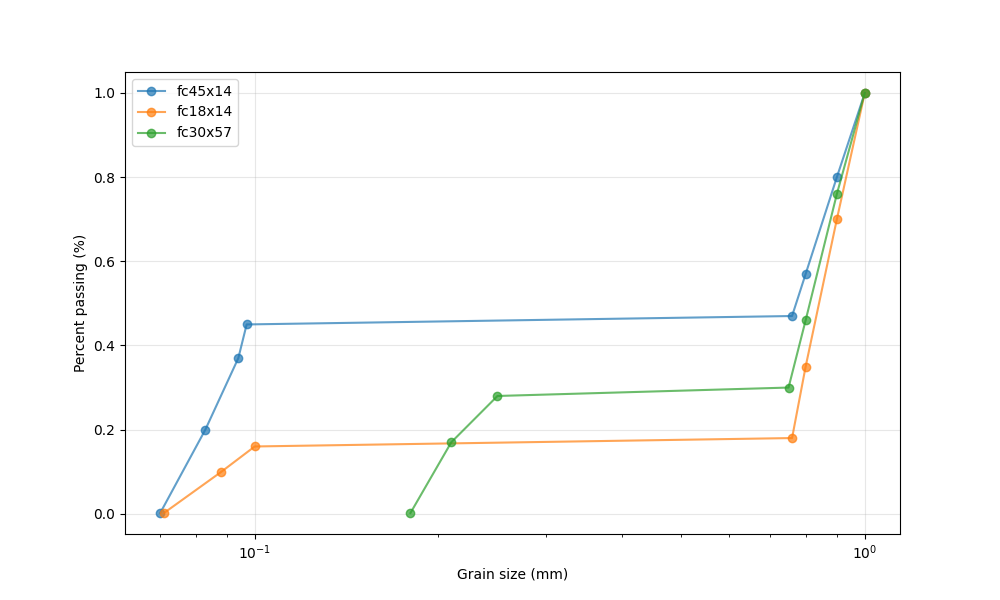

In [132]:
# Example: Access the first dataset
dataset_name = list(datasets.keys())[0]
x_data = datasets[dataset_name]["x"]
y_data = datasets[dataset_name]["y"]

# Or access by specific name if you know it
# x_data = datasets['dataset1']['x']
# y_data = datasets['dataset1']['y']

tol = 1e-3

gsd_list = []
mps_list = []
# Plot all datasets
figure, ax = plt.subplots(figsize=(10, 6))
for name, data in datasets.items():
    ax.plot(data["x"], data["y"], "o-", label=name, alpha=0.7)  
    sizes = data["x"]
    sizes = np.insert(sizes, 0, sizes[0]/2)  # Add a point at 10x the last size
    masses = data["y"]
    masses = np.insert(masses, 0, 0)  # Add a point at 10x the last mass
    retained = np.zeros(len(sizes))
    for i in range(len(masses) - 1):
        retained[i] = masses[i + 1] - masses[i]

    masses = retained
    g = GSD(sizes=sizes, masses=masses)
    mps = MinimalPackingGenerator(
        g, x_n_factor=1, tol=tol, flex=True, density=1.0
    )
    gsd_list.append(g)
    mps_list.append(mps)


ax.set_xlabel("Grain size (mm)")
ax.set_ylabel("Percent passing (%)")
ax.set_xscale("log")
ax.legend()
ax.grid(True, alpha=0.3)


(0.055, 100)

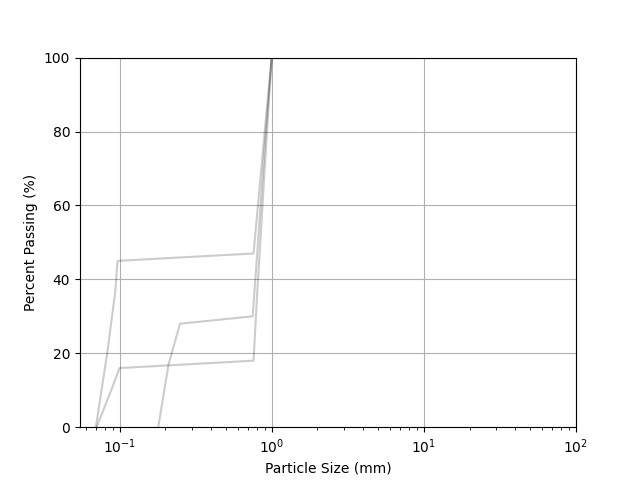

In [133]:
# Plot the grain size distributions
plt.close("all")
fig, ax = plt.subplots()
for gsd in gsd_list:
    ax.plot(gsd.sizes[1:], 100 * gsd.percent_passing[1:], color="k", alpha=0.2)
ax.set_xscale("log")
ax.grid()  # (True, which='both', axis='both')
ax.set_xlabel("Particle Size (mm)")
ax.set_ylabel("Percent Passing (%)")
ax.set_ylim(0, 100)
ax.set_xlim(0.055, 100)


In [134]:
for i in range(len(gsd_list)):
    gsd = gsd_list[i]
    mps = mps_list[i]
    print(f"\nDataset {i + 1}:")
    NC = sum(mps.qs[-1][-4:])
    NF = sum(mps.qs[-1]) - NC
    Nratio = NF/NC
    print(f" Nratio: {Nratio}")
    # print(f"  Sizes: {gsd.sizes}")
    # print(f"  Masses: {gsd.masses}")
    # print(f"  Minimal Packing Sizes: {mps.mps.sizes}")
    # print(f"  NC: {sum(mps.qs[-1][-4:])}")
    # print(f" NF: {sum(mps.qs[-1]) - sum(mps.qs[-1][-4:])}")


Dataset 1:
 Nratio: 644.8

Dataset 2:
 Nratio: 163.8235294117647

Dataset 3:
 Nratio: 21.4


In [136]:
130072/4408

29.508166969147005

In [116]:
d_ratios = np.array([5.7, 8, 14.3])
fcs = [0.18, 0.25, 0.3, 0.35, 0.45]
d_max = 1.0 # mm
pan_size = 0.001 # mm
upper_screen = d_max * 1.0001
d_mins = list(d_max / d_ratios)
i = 0
gsd_list = []
mps_list = []
for d_min in d_mins:
    for fc in fcs:
        size = [pan_size, d_min, d_max, upper_screen]
        mass = [fc, 0, 1-fc, 0]
        mr = fc / (1 - fc)
        g = GSD(sizes=size, masses=mass)
        mps = MinimalPackingGenerator(g, x_n_factor=0.9, tol=1e-2, flex=True, density=1.0)
        gsd_list.append(g)
        mps_list.append(mps)
    # print(f"Predicted mass for d_min={d_min:.2f} mm, fc={fc:.2f}: {pred:.2f} g")
    # print(f"Predicted mass per particle: {pred / NP:.2f} g")


In [119]:
for i in range(len(gsd_list)):
    gsd = gsd_list[i]
    mps = mps_list[i]
    print(f"\nDataset {i + 1}:")
    print(f"MPS: {sum(mps.qs[-1])}, Times NC: {sum(mps.qs[-1]) * 4000:,.0f}")
    # print(f"  Sizes: {gsd.sizes}")
    # print(f"  Masses: {gsd.masses}")
    # print(f"  Minimal Packing Sizes: {mps.mps.sizes}")
    # print(f"  Minimal Packing Masses: {mps.qs[-1]}")



Dataset 1:
MPS: 42, Times NC: 168,000

Dataset 2:
MPS: 63, Times NC: 252,000

Dataset 3:
MPS: 81, Times NC: 324,000

Dataset 4:
MPS: 101, Times NC: 404,000

Dataset 5:
MPS: 153, Times NC: 612,000

Dataset 6:
MPS: 114, Times NC: 456,000

Dataset 7:
MPS: 172, Times NC: 688,000

Dataset 8:
MPS: 221, Times NC: 884,000

Dataset 9:
MPS: 277, Times NC: 1,108,000

Dataset 10:
MPS: 421, Times NC: 1,684,000

Dataset 11:
MPS: 644, Times NC: 2,576,000

Dataset 12:
MPS: 976, Times NC: 3,904,000

Dataset 13:
MPS: 1255, Times NC: 5,020,000

Dataset 14:
MPS: 1576, Times NC: 6,304,000

Dataset 15:
MPS: 2395, Times NC: 9,580,000


In [120]:
NCP = 4320
NFP = 64184

vmax = 4 * np.pi * (d_max/2)**3 / 3
vmin = 4 * np.pi * (d_max/5.71/2)**3 / 3
MC = vmax * NCP
MFP = vmin * NFP
MT = MC + MFP
fc = MFP / MT


In [121]:
fc

0.07390758867454644